## Post Processing
GTやFuel Demandの部分についての汎用化を行うために"GT_heatrate"と"Add_Fuel_Demand"について条件を振ったデータセットの再構築を行う。  
新しいデータセットを作るにあたっては以下2通りを検討した。
- Case1 元データセットをすべての組み合わせ　× 指定した"GT_heatrate"と"Add_Fuel_Demand"のすべての組み合わせ
- Case2 元データセットからランダム抽出 ＋ "GT_heatrate"と"Add_Fuel_Demand"をランダム抽出  
のちのBest Parameter算出の検証において、Case2ではうまくピークが得られなかったため、Case1を採用することになった。

## Post Processing (As per Google Translate)
Reconstruct the dataset with conditions for "GT_heatrate" and "Add_Fuel_Demand" in order to generalize the GT and Fuel Demand parts.
In creating a new data set, we considered the following two methods.
- Case1 All combinations of the original data set × All combinations of the specified "GT_heatrate" and "Add_Fuel_Demand"
- Case2 Random sampling from the original dataset + Random sampling of "GT_heatrate" and "Add_Fuel_Demand"

In the later verification of the Best Parameter calculation, Case 2 did not give a good peak, so Case 1 was adopted.

### ライブラリー、モデル、データセットの読み込み (Loading libraries, models and datasets)

In [1]:
import sys, os, math
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import *
import gc
from tqdm import tqdm #時間表示用(Time indication)

pd.set_option('display.max_columns', 200) #df表示数増加(df means number increase)

In [3]:
# # # データセットの読み込み(Data set loading)
# path = '../../LngGeneralModel_CPW-master1/dataset_preprocessed_11.pkl'
# df_raw = pd.read_pickle(path)
# df_raw.reset_index(inplace=True, drop=True) 
# print("df_raw.shape:", df_raw.shape)

# Count File Numbers
data_dir = '/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/preprocessed'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_num:",file_num)
print(data_filelist)

# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    print(file_dir)
    df_tmp = pd.read_csv(file_dir) #read_pickle
    df_raw = pd.concat([df_raw, df_tmp])
df_raw.reset_index(drop=True, inplace=True)
print("df_raw.shape:", df_raw.shape)

df_raw.describe()

file_num: 12
['dataset_preprocessed_11.pkl', 'dataset_preprocessed_10.pkl', 'dataset_preprocessed_0.pkl', 'dataset_preprocessed_1.pkl', 'dataset_preprocessed_2.pkl', 'dataset_preprocessed_3.pkl', 'dataset_preprocessed_9.pkl', 'dataset_preprocessed_4.pkl', 'dataset_preprocessed_5.pkl', 'dataset_preprocessed_8.pkl', 'dataset_preprocessed_6.pkl', 'dataset_preprocessed_7.pkl']
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/preprocessed/dataset_preprocessed_11.pkl


ValueError: ignored

In [ ]:
# # Pre-processing: UA Extraction
# df_raw_temp = df_raw.copy()
# df_raw = df_raw[(df_raw['WB_UA'] > 1.5 * 10**7) & (df_raw['WB_UA'] < 6 * 10**7)]
# df_raw = df_raw[(df_raw['CB_UA'] > 0.75 * 10**6) & (df_raw['CB_UA'] < 3 * 10**6)]
# df_raw.reset_index(inplace=True, drop=True) # Indexを振りなおす(Re-roll)

# df_raw.describe()

UA抽出結果(Extraction result) 

データ数(The number of data) 137772 → 71383 

WB_UA 最小値(Min value):  1.00e+07 → 1.50e+07
WB_UA 最頻値(Mode):  3.35e+07 → 3.35e+07
WB_UA 中央値(Median):  3.85e+07 → 3.27e+07
WB_UA 平均値(Mean):  4.66e+07 → 3.44e+07
WB_UA 最大値(Max value):  1.50e+08 → 6.00e+07 

CB_UA 最小値(Min value):  1.15e+05 → 7.50e+05
CB_UA 最頻値(Mode):  1.39e+06 → 1.39e+06
CB_UA 中央値(Median):  1.69e+06 → 1.51e+06
CB_UA 平均値(Mean):  2.22e+06 → 1.62e+06
CB_UA 最大値(Max value):  1.00e+07 → 3.00e+06 



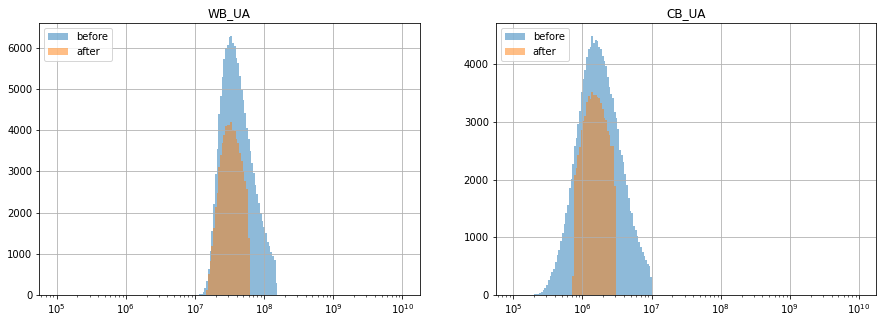

In [ ]:
# Pre-processing_2 UA Extraction
UA_list = ['WB_UA', 'CB_UA']

df_raw_temp = df_raw.copy()

# UAの外れ値を除外(Exclude outliers)
df_raw = df_raw[(df_raw['WB_UA'] > 1.5 * 10**7) & (df_raw['WB_UA'] < 6 * 10**7)]
df_raw = df_raw[(df_raw['CB_UA'] > 0.75 * 10**6) & (df_raw['CB_UA'] < 3 * 10**6)]
df_raw.reset_index(inplace=True, drop=True) # Indexを振りなおす(Re-roll)

print("UA抽出結果(Extraction result)","\n")
print("データ数(The number of data)", df_raw_temp.shape[0], "→", df_raw.shape[0],"\n")

# 可視化(Visualization)
num_row = math.ceil(len(df_raw.loc[:, UA_list].columns) / 2)

plt.figure(figsize=(15, 5 * num_row))
i = 0

for tag in df_raw.loc[:, UA_list].columns:
    i += 1
    plt.subplot(num_row, 2, i)
    n_raw, bins_raw, patches_raw = plt.hist(x=df_raw_temp[tag], bins=np.logspace(5, 10, 200), alpha=0.5, label="before")
    n, bins, patches = plt.hist(df_raw[tag], bins=np.logspace(5, 10, 200), alpha=0.5, label="after")
    plt.legend(loc="upper left")
    plt.xscale('log')
    plt.grid()
    plt.title(label=tag)
    mode_index_raw = n_raw.argmax()
    mode_index = n.argmax()
    print(tag, '最小値(Min value): ', f"{df_raw_temp[tag].min():.2e}", "→", f"{df_raw[tag].min():.2e}")
    print(tag, '最頻値(Mode): ', f"{(bins_raw[mode_index_raw] + bins[mode_index_raw+1])/2:.2e}", "→", f"{(bins[mode_index] + bins[mode_index+1])/2:.2e}")
    print(tag, '中央値(Median): ', f"{df_raw_temp[tag].median():.2e}", "→", f"{df_raw[tag].median():.2e}")
    print(tag, '平均値(Mean): ', f"{df_raw_temp[tag].mean():.2e}", "→", f"{df_raw[tag].mean():.2e}")
    print(tag, '最大値(Max value): ', f"{df_raw_temp[tag].max():.2e}", "→", f"{df_raw[tag].max():.2e}","\n")


plt.show()

In [ ]:
# Columnの抽出用 - dfには不要な列も含むため、以下に指定したTag (list_total) のみを最終的なOutputのdfの列として抽出する。
# For column extraction 
# --Since df includes unnecessary columns, only the Tag (list_total) specified below is extracted as the final Output df column.

# explanatory variable - given
list_u = [
    'FEED_N2', 'FEED_C1', 'FEED_C2', 'FEED_C3',#     'FEED_iC4',#     'FEED_nC4',    # 'FEED_C5+',
    'AmbTemp', 'Cond_Out_Temp_AFC',    # 'MCHE_IN_T',
    'WB_UA', 'CB_UA', 'MR_HT_Eff', 'Feed_Press', 'Feed_Temp'
]

# explanatory variable - given (additional)
list_u2 = ["GT_heatrate", "Add_Fuel_Demand"]

# explanatory variable - search
list_v = [
    'HPMR_Dis_Press', 'LPMR_Suc_Press', 'MCHE_WB_DT',
    'MR_N2', 'MR_C1', 'MR_C2', 'MR_C3',#     'MR_C4'
]

list_x = list_u + list_u2 + list_v

# target variable
list_y = [
    "MCHE_CB_Out_Temp",
    "FFF_Flow_GenGT_1", "FFF_Flow_act_GenGT_1", "ThermalEff_GenGT_1", "SpecPower_GenGT_1",
    "FFF_Flow_GenGT_2", "FFF_Flow_act_GenGT_2", "ThermalEff_GenGT_2", "SpecPower_GenGT_2",
    "FFF_Flow_GenGT_3", "FFF_Flow_act_GenGT_3", "ThermalEff_GenGT_3", "SpecPower_GenGT_3",   
]

# other variable
list_o = ["FEED_MassFlow"]

list_total = list_x + list_y + list_o

## データセットの構築(Dataset construction)

In [ ]:
# Case 1 全件使用(Full use)
cols = df_raw.columns.values.tolist() + ["GT_heatrate","Add_Fuel_Demand"]

heat_rate_list = [9000, 10000, 11000, 12000]
fuel_demand_list = [0, 5*1000, 10*1000, 20*1000]

file_num = 50

for j in tqdm(range(0, file_num)):
    row_num = df_raw.shape[0]//file_num
    df_temp = df_raw[j*row_num:(j+1)*row_num].copy()
    df = pd.DataFrame(index=[], columns=[])
 
    for _, item in df_temp.iterrows():
        for GT_heatrate in heat_rate_list:
            for Additional_Fuel_Demand in fuel_demand_list:
                row = pd.DataFrame(np.concatenate([item.values, [GT_heatrate, Additional_Fuel_Demand]])).T
                df = pd.concat([df, row], axis=0)

    df.index = range(df_temp.shape[0] * len(heat_rate_list)*len(fuel_demand_list))
    df.columns = cols            

    for i in range(1,4): #Rundownのそれぞれのパターン(1_Direct, 2_LNG_HT, 3_EFG)毎に計算 (Calculated for each Rundown pattern (1_Direct, 2_LNG_HT, 3_EFG))
        comp_heat = df["comp_power_total"] * df["GT_heatrate"] #kJ/h, CompressorへのFuel必要熱量 (Fuel required heat for Compressor)
        LNG_heat = df["LNG_Prod_{}".format(i)] * df["LNG_LHV_{}".format(i)]
        EFG_heat = df["EFG_{}".format(i)] * df["EFG_LHV_{}".format(i)]
        BOG_heat = df["BOG"] * df["EFG_LHV_{}".format(i)]
        Additional_heat = df["Add_Fuel_Demand"] * df["EFG_LHV_{}".format(i)]

        # FFF計算 (FFF calculation)
        FFF_heat = comp_heat + Additional_heat - EFG_heat - BOG_heat

        # EFGが過多で、FFFが負となる場合はEFGが一部Flaringしているとみなす
        # If there is too much EFG and FFF is negative, it is considered that EFG is partially flaring.
        FFF_heat_act = FFF_heat.copy()
        FFF_heat_act[FFF_heat_act<= 0] = 0

        # FFF量をdfに追加 (Added FFF amount to df)
        df["FFF_Flow_GenGT_{}".format(i)] = FFF_heat / df["FEED_LHV"]
        df["FFF_Flow_act_GenGT_{}".format(i)] = FFF_heat_act / df["FEED_LHV"]

        # Thermal Efficiencyをdfに追加 (Added Thermal Efficiency to df)
        ThermalEff = (LNG_heat + df["Cond_heat"] - BOG_heat) / (FFF_heat_act + df["liquefaction_feed_heat"])
        df["ThermalEff_GenGT_{}".format(i)] = ThermalEff

        # Specific Powerをdfに追加 (Added Specific Power to df)
        SpecPower = df["comp_power_total"] / df["LNG_Prod_{}".format(i)] * 1000
        df["SpecPower_GenGT_{}".format(i)] = SpecPower   

    df = df[list_total]

    print(j, df.shape)
#     print(df)
    df.to_csv('../../LngGeneralModel_CPW_master/results_CaseA/dataset_postprocessed_{}.csv'.format(j))
    del df
    gc.collect()

  0%|                                                                                                                                                                                                              | 0/50 [00:00<?, ?it/s]

0 (22832, 34)


  2%|███▉                                                                                                                                                                                                | 1/50 [01:29<1:13:05, 89.51s/it]

1 (22832, 34)


  4%|███████▊                                                                                                                                                                                            | 2/50 [02:58<1:11:21, 89.20s/it]

2 (22832, 34)


  6%|███████████▊                                                                                                                                                                                        | 3/50 [04:28<1:10:09, 89.57s/it]

3 (22832, 34)


  8%|███████████████▋                                                                                                                                                                                    | 4/50 [05:57<1:08:35, 89.46s/it]

4 (22832, 34)


 10%|███████████████████▌                                                                                                                                                                                | 5/50 [07:26<1:06:59, 89.33s/it]

5 (22832, 34)


 12%|███████████████████████▌                                                                                                                                                                            | 6/50 [08:55<1:05:15, 89.00s/it]

6 (22832, 34)


 14%|███████████████████████████▍                                                                                                                                                                        | 7/50 [10:23<1:03:32, 88.67s/it]

7 (22832, 34)


 16%|███████████████████████████████▎                                                                                                                                                                    | 8/50 [11:50<1:01:51, 88.38s/it]

8 (22832, 34)


 18%|███████████████████████████████████▎                                                                                                                                                                | 9/50 [13:19<1:00:23, 88.37s/it]

9 (22832, 34)


 20%|███████████████████████████████████████▍                                                                                                                                                             | 10/50 [14:47<58:56, 88.41s/it]

10 (22832, 34)


 22%|███████████████████████████████████████████▎                                                                                                                                                         | 11/50 [16:14<57:11, 87.97s/it]

11 (22832, 34)


 24%|███████████████████████████████████████████████▎                                                                                                                                                     | 12/50 [17:43<55:48, 88.13s/it]

12 (22832, 34)


 26%|███████████████████████████████████████████████████▏                                                                                                                                                 | 13/50 [19:12<54:29, 88.38s/it]

13 (22832, 34)


 28%|███████████████████████████████████████████████████████▏                                                                                                                                             | 14/50 [20:40<52:57, 88.26s/it]

14 (22832, 34)


 30%|███████████████████████████████████████████████████████████                                                                                                                                          | 15/50 [22:09<51:34, 88.41s/it]

15 (22832, 34)


 32%|███████████████████████████████████████████████████████████████                                                                                                                                      | 16/50 [23:36<49:54, 88.08s/it]

16 (22832, 34)


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                  | 17/50 [25:04<48:28, 88.14s/it]

17 (22832, 34)


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                              | 18/50 [26:33<47:11, 88.47s/it]

18 (22832, 34)


 38%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 19/50 [28:02<45:47, 88.61s/it]

19 (22832, 34)


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 20/50 [29:30<44:12, 88.42s/it]

20 (22832, 34)


 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 21/50 [30:58<42:38, 88.24s/it]

21 (22832, 34)


 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 22/50 [32:27<41:16, 88.45s/it]

22 (22832, 34)


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 23/50 [33:56<39:50, 88.56s/it]

23 (22832, 34)


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 24/50 [35:25<38:25, 88.66s/it]

24 (22832, 34)


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 25/50 [36:54<36:59, 88.80s/it]

25 (22832, 34)


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 26/50 [38:23<35:32, 88.86s/it]

26 (22832, 34)


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 27/50 [39:52<34:07, 89.02s/it]

27 (22832, 34)


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 28/50 [41:22<32:41, 89.14s/it]

28 (22832, 34)


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 29/50 [42:49<31:00, 88.60s/it]

29 (22832, 34)


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 30/50 [44:17<29:27, 88.39s/it]

30 (22832, 34)


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 31/50 [45:42<27:41, 87.44s/it]

31 (22832, 34)


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 32/50 [47:08<26:07, 87.11s/it]

32 (22832, 34)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 33/50 [48:34<24:35, 86.77s/it]

33 (22832, 34)


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 34/50 [50:01<23:07, 86.75s/it]

34 (22832, 34)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 35/50 [51:27<21:39, 86.62s/it]

35 (22832, 34)


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 36/50 [52:54<20:13, 86.71s/it]

36 (22832, 34)


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 37/50 [54:21<18:46, 86.64s/it]

37 (22832, 34)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 38/50 [55:48<17:20, 86.70s/it]

38 (22832, 34)


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 39/50 [57:14<15:52, 86.55s/it]

39 (22832, 34)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 40/50 [58:41<14:28, 86.80s/it]

40 (22832, 34)


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 41/50 [1:00:07<12:57, 86.41s/it]

41 (22832, 34)


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 42/50 [1:01:34<11:33, 86.63s/it]

42 (22832, 34)


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 43/50 [1:02:59<10:04, 86.29s/it]

43 (22832, 34)


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 44/50 [1:04:27<08:39, 86.61s/it]

44 (22832, 34)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 45/50 [1:05:55<07:15, 87.02s/it]

45 (22832, 34)


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 46/50 [1:07:01<05:23, 80.81s/it]

46 (22832, 34)


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 47/50 [1:08:04<03:46, 75.34s/it]

47 (22832, 34)


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 48/50 [1:09:06<02:23, 71.52s/it]

48 (22832, 34)


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 49/50 [1:10:09<01:08, 68.86s/it]

49 (22832, 34)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:11:12<00:00, 85.44s/it]


In [ ]:
# 全pickleデータの結合
# データのファイル数をカウント
data_dir = '../output/postprocessed'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("ファイル数:", file_num)

# データを読み込み、1つのDataframeに結合
df_combined = pd.DataFrame()  # 最終的にまとめるDataframe
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    df_tmp = pd.read_pickle(file_dir)
    df_combined = pd.concat([df_combined, df_tmp])
df_combined.reset_index(drop=True, inplace=True)  # 行のIndexをリセット
print(df_combined.shape)
print("duplicates:", df_combined.duplicated().sum())  # 重複行がないか確認
df_combined.describe()

df_combined.to_pickle('../output/postprocessed/dataset_postprocessed.pkl')